In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('/content/drive/My Drive/496 project/raw_sales.csv')

# Convert 'datesold' column to datetime data type
df['datesold'] = pd.to_datetime(df['datesold'])


# Encode non-numeric data (here we use one-hot encoding)
df_encoded = pd.get_dummies(df, columns=['propertyType'])

# data standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_encoded[['price', 'bedrooms']] = scaler.fit_transform(df_encoded[['price', 'bedrooms']])

# Sequence data processing (here we sort the data by date and reset the index)
df_encoded.sort_values(by='datesold', inplace=True)
df_encoded.reset_index(drop=True, inplace=True)

print(df_encoded)


        datesold  postcode     price  bedrooms  propertyType_house  \
0     2007-02-07      2607 -0.300800  0.788251                   1   
1     2007-02-27      2906 -1.135011 -0.262987                   1   
2     2007-03-07      2905 -1.000118 -0.262987                   1   
3     2007-03-09      2905 -0.815526  0.788251                   1   
4     2007-03-21      2906 -1.064015 -0.262987                   1   
...          ...       ...       ...       ...                 ...   
29575 2019-07-26      2902  0.169553  0.788251                   1   
29576 2019-07-26      2601 -0.073610 -1.314226                   0   
29577 2019-07-27      2905  0.000936  0.788251                   1   
29578 2019-07-27      2615  0.134055  0.788251                   1   
29579 2019-07-27      2905  0.906144  1.839490                   1   

       propertyType_unit  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0

In [6]:
df_encoded.head()

,datesold,postcode,price,bedrooms,propertyType_house,propertyType_unit
0,2007-02-07,2607,-0.300800,0.788251,1,0
1,2007-02-27,2906,-1.135011,-0.262987,1,0
2,2007-03-07,2905,-1.000118,-0.262987,1,0
3,2007-03-09,2905,-0.815526,0.788251,1,0
4,2007-03-21,2906,-1.064015,-0.262987,1,0


In [7]:
# Define a function to remove outliers from grouped data
def remove_outliers(group):
    Q1 = group['price'].quantile(0.25)
    Q3 = group['price'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group['price'] >= lower_bound) & (group['price'] <= upper_bound)]

# Add a 'year' column to the data, indicating the year of each data
df['year'] = df['datesold'].dt.year

# Use the groupby function to group by the 'year' and 'postcode' columns and apply the remove_outliers function
df = df.groupby(['year', 'postcode']).apply(remove_outliers).reset_index(drop=True)

# Remove the 'year' column as we don't need it anymore
df.drop('year', axis=1, inplace=True)


In [8]:
from sklearn.preprocessing import MinMaxScaler
# First, one-hot encode the non-numeric features
df = pd.get_dummies(df, columns=['propertyType'])

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['price', 'bedrooms', 'propertyType_house', 'propertyType_unit']])

# Convert normalized data back to DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=['price', 'bedrooms', 'propertyType_house', 'propertyType_unit'])
scaled_df['datesold'] = df['datesold']
scaled_df['postcode'] = df['postcode']
# group by region
grouped_data = scaled_df.groupby('postcode')



In [36]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense


# Define a function for converting time series data into supervised learning data
def to_supervised(data, n_in=1, n_out=1):
    n_vars = data.shape[1]
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(data.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(data.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    supervised_data = pd.concat(cols, axis=1)
    supervised_data.columns = names
    supervised_data.dropna(inplace=True)
    return supervised_data


def train_rnn_model(train_data, n_input, n_features):
    # Separate input features and target variables
    X_train, y_train = train_data[:, :n_features*3], train_data[:, -4]

    # Reshape the input data to meet the input requirements of the RNN
    X_train = X_train.reshape((X_train.shape[0], n_input, n_features))

    # Build the RNN model
    model = Sequential()
    model.add(SimpleRNN(50, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # training model
    model.fit(X_train, y_train, epochs=200, verbose=0)

    return model




In [37]:

def predict_next_period(model, last_n_periods_data, n_input, n_features):
    # Reshape the input data to meet the input requirements of the RNN
    X_test = last_n_periods_data.reshape((1, n_input, n_features))
    
    # Use the trained model to make predictions
    y_pred = model.predict(X_test)
    
    return y_pred[0, 0]

In [38]:
def plot_true_vs_predicted(y_true, y_pred, title="True vs. Predicted"):
    plt.plot(y_true, label="True")
    plt.plot(y_pred, label="Predicted")
    plt.title(title)
    plt.legend()

In [ ]:
from sklearn.metrics import mean_squared_error

n_input = 3
n_features = 5
postcode_rmse_train = {}
postcode_rmse_val = {}
i = 1

for postcode, group in grouped_data:
    group.sort_values(by='datesold', inplace=True)
    group.reset_index(drop=True, inplace=True)

    data = group.drop(columns=['datesold','postcode']).values.astype('float32')

    # Transform data into supervised learning data
    supervised_data = to_supervised(pd.DataFrame(data), n_in=n_input)
    train_data = supervised_data.values
    # Divide the data into training and validation sets
    train_size = int(len(train_data) * 0.7)
    train_data_train = train_data[:train_size]
    train_data_val = train_data[train_size:]

    
    # Extract the input and output of the training set and validation set
    X_train = train_data_train[:, :n_features*3].reshape((-1, n_input, n_features))
    y_train = train_data_train[:, -4]
    X_val = train_data_val[:, :n_features*3].reshape((-1, n_input, n_features))
    y_val = train_data_val[:, -4]
    # Create and train an RNN model
    rnn_model = train_rnn_model(train_data_train, n_input, n_features)

    # Prepare test data (here we use the data from the last n_input period as input)
    last_n_periods_data = train_data[-1, -n_features * n_input:]

    # Predict the price of the next period
    next_period_price = predict_next_period(rnn_model, last_n_periods_data, n_input, n_features)
    print(f"Predicted price for next period in postcode {postcode}: {next_period_price}")

    # Calculate the evaluation metrics for the predicted results
    y_train_pred = rnn_model.predict(X_train)
    y_val_pred = rnn_model.predict(X_val)

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_val = np.sqrt(mean_squared_error(y_val,y_val_pred))

    # Draw a comparison chart
    plt.subplot(9,3,i)
    plot_true_vs_predicted(np.concatenate((y_train,y_val)), np.concatenate((y_train_pred,y_val_pred)), title=f"True vs. Predicted for postcode {postcode}")
    i += 1
    

    # save the RMSE result into a dictionary
    postcode_rmse_train[postcode] = rmse_train
    postcode_rmse_val[postcode] = rmse_val

plt.show()

1/1 [==============================] - 0s 160ms/step
Predicted price for next period in postcode 2600: 0.29469364881515503
1/1 [==============================] - 0s 279ms/step
Predicted price for next period in postcode 2601: 0.27069589495658875
1/1 [==============================] - 0s 231ms/step
Predicted price for next period in postcode 2602: 0.5954762697219849
24/24 [==============================] - 0s 2ms/step


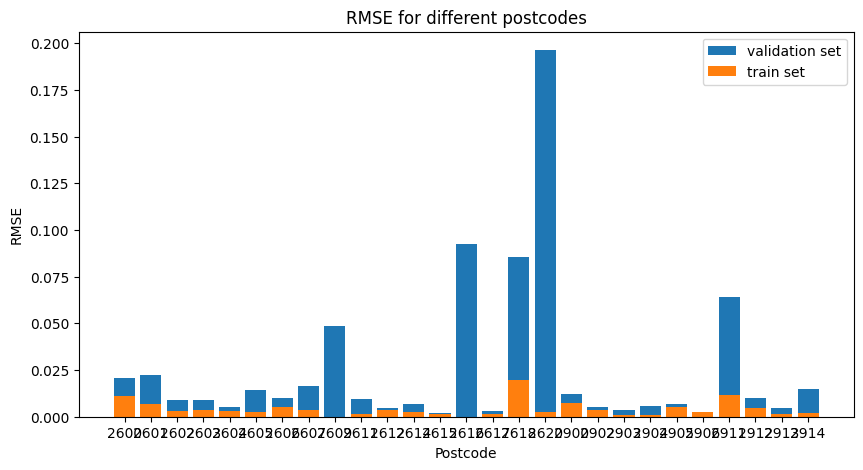

In [24]:
# convert dictionary to list
postcodes = list(postcode_rmse_train.keys())
rmse_values_train = list(postcode_rmse_train.values())
rmse_values_val = list(postcode_rmse_val.values())
postcodes = [str(a) for a in postcodes]
# draw histogram
plt.figure(figsize=(10, 5))
plt.bar(postcodes, rmse_values_val, label = 'validation set')
plt.bar(postcodes, rmse_values_train, label = 'train set')
plt.xlabel("Postcode")
plt.ylabel("RMSE")
plt.title("RMSE for different postcodes")
plt.legend()
plt.show()

In [18]:
from keras.callbacks import EarlyStopping
def train_rnn_model(train_data, n_input, n_features, validation_data=None):
    # Separate input features and target variables
    X_train, y_train = train_data[:, :n_features*3], train_data[:, -4]

    # Reshape the input data to meet the input requirements of the RNN
    X_train = X_train.reshape((X_train.shape[0], n_input, n_features))

    # Build the RNN model
    model = Sequential()
    model.add(SimpleRNN(50, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Add EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    callbacks = [early_stopping] if validation_data is not None else None

    # Add validation data and callbacks in the fit function
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0, validation_data=validation_data, callbacks=callbacks)

    return model

In [22]:
from sklearn.metrics import mean_squared_error

n_input = 3
n_features = 5
postcode_rmse_train_es = {}
postcode_rmse_val_es = {}

for postcode, group in grouped_data:
    group.sort_values(by='datesold', inplace=True)
    group.reset_index(drop=True, inplace=True)

    data = group.drop(columns=['datesold','postcode']).values.astype('float32')

    # Transform data into supervised learning data
    supervised_data = to_supervised(pd.DataFrame(data), n_in=n_input)
    train_data = supervised_data.values
    # Divide the data into training and validation sets
    train_size = int(len(train_data) * 0.7)
    train_data_train = train_data[:train_size]
    train_data_val = train_data[train_size:]

    
    # Extract the input and output of the training set and validation set
    X_train = train_data_train[:, :n_features*3].reshape((-1, n_input, n_features))
    y_train = train_data_train[:, -4]
    X_val = train_data_val[:, :n_features*3].reshape((-1, n_input, n_features))
    y_val = train_data_val[:, -4]
    # Create and train an RNN model
    rnn_model = train_rnn_model(train_data_train, n_input, n_features)

    # Prepare test data (here we use the data from the last n_input period as input)
    last_n_periods_data = train_data[-1, -n_features * n_input:]

    # Predict the price of the next period
    next_period_price = predict_next_period(rnn_model, last_n_periods_data, n_input, n_features)
    print(f"Predicted price for next period in postcode {postcode}: {next_period_price}")

    # Calculate the evaluation metric of the forecast
    y_train_pred = rnn_model.predict(X_train)
    y_val_pred = rnn_model.predict(X_val)

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_val = np.sqrt(mean_squared_error(y_val,y_val_pred))

    # Draw a comparison chart
    plt.subplot(9,3,i)
    plot_true_vs_predicted(np.concatenate((y_train,y_val)), np.concatenate((y_train_pred,y_val_pred)), title=f"True vs. Predicted for postcode {postcode}")
    i += 1
    
    # save the RMSE result into a dictionary
    postcode_rmse_train_es[postcode] = rmse_train
    postcode_rmse_val_es[postcode] = rmse_val

plt.show()


1/1 [==============================] - 0s 153ms/step
Predicted price for next period in postcode 2600: 0.32593435049057007
1/1 [==============================] - 0s 173ms/step
Predicted price for next period in postcode 2601: 0.24543794989585876
1/1 [==============================] - 0s 152ms/step
Predicted price for next period in postcode 2602: 0.5558010935783386
1/1 [==============================] - 0s 156ms/step
Predicted price for next period in postcode 2603: 0.18358072638511658
1/1 [==============================] - 0s 140ms/step
Predicted price for next period in postcode 2604: 0.34671854972839355
1/1 [==============================] - 0s 146ms/step
Predicted price for next period in postcode 2605: 0.5717599391937256
1/1 [==============================] - 0s 161ms/step
Predicted price for next period in postcode 2606: 0.1929619163274765
1/1 [==============================] - 0s 149ms/step
Predicted price for next period in postcode 2607: 0.4462819993495941
1/1 [===============

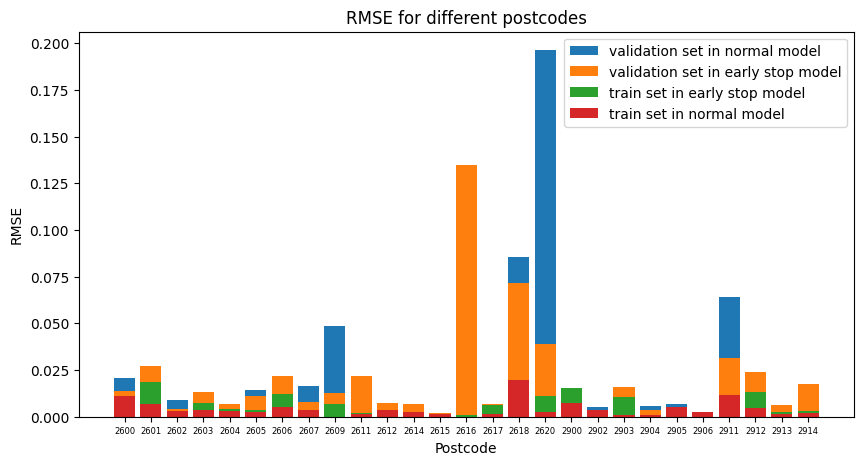

In [34]:

# convert dictionary to list
postcodes = list(postcode_rmse_train_es.keys())
rmse_values_train = list(postcode_rmse_train.values())
rmse_values_val = list(postcode_rmse_val.values())
rmse_values_train_es = list(postcode_rmse_train_es.values())
rmse_values_val_es = list(postcode_rmse_val_es.values())
postcodes = [str(a) for a in postcodes]
# draw histogram
plt.figure(figsize=(10, 5))
plt.bar(postcodes, rmse_values_val, label = 'validation set in normal model')
plt.bar(postcodes, rmse_values_val_es, label = 'validation set in early stop model')
plt.bar(postcodes, rmse_values_train_es, label = 'train set in early stop model')
plt.bar(postcodes, rmse_values_train, label = 'train set in normal model')

plt.xlabel("Postcode")
plt.tick_params(axis='x', labelsize=6)    
plt.ylabel("RMSE")
plt.title("RMSE for different postcodes")
plt.legend()
plt.show()